## Home Credit Default Risk

## PART 2: Подготовка данных. Новые признаки.

В этом ноутбуке данные подготавливаются для работы с моделями: кодирование, заполнение пропущенных значений, генерация новых признаков. 

In [1]:
import numpy as np
import pandas as pd
import pickle

from eda_module import *
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
sns.set_style('whitegrid')
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 250)

In [2]:
df_application_train = pd.read_csv('data/application_train.csv')
df_application_test = pd.read_csv('data/application_test.csv')

print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 122)
application test: (48744, 121)


In [3]:
with open('columns_vocab.pkl', 'rb') as f: 
    columns_vocab = pickle.load(f)
    
APPL_ID = 0
columns_vocab[APPL_ID].keys()

dict_keys(['column_id', 'column_target', 'columns_binary', 'columns_category', 'columns_float', 'columns_float_avg', 'columns_float_mode', 'columns_float_medi', 'columns_float_social_circle', 'new_features', 'columns_category_ohe', 'columns_float_log', 'columns_social_circle_log'])

### Генерация новых признаков

Я попробую сделать новые признаки на основе уже имеющихся, которые показались обнадеживающими в предварительном анализе. Ну и забегая немного вперед, эти признаки **EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH** действительно будут иметь высокий feature importance в моделях. Часть признаков придумывались исходя из "житейской логики", часть просто различные комбинации, некоторые я подглядела в кернелах. Вообще неизвестно, что означает группа EXT_SOURCE и не совсем понятно, как лучше их использовать в комбинациях с другими. Наверное, это какая-то дополнительная внешняя информация о заемщиках. 

In [4]:
def is_top_AMT_GOODS_PRICE(value):
    top_values = [450000, 225000, 675000, 900000, 270000, 180000]
    if value in top_values:
        return 1
    else:
        return 0
    
def new_features(df, is_train=True):
    year_days_mean = (365+365+365+366)/4
    delta = 0.001
    new_df = pd.DataFrame()
    if is_train:
        new_df['TARGET'] = df['TARGET']
        
    new_df['DAYS_EMPLOYED_upd'] = np.exp(df['DAYS_EMPLOYED']/year_days_mean/250)
    
    new_df['AMT_INCOME_TOTAL / DAYS_BIRTH'] = df['AMT_INCOME_TOTAL']/(-1)*df['DAYS_BIRTH']
    new_df['AMT_INCOME_TOTAL / DAYS_EMPLOYED_upd'] = df['AMT_INCOME_TOTAL']/new_df['DAYS_EMPLOYED_upd']
    new_df['AMT_INCOME_TOTAL / OWN_CAR_AGE'] = df['AMT_INCOME_TOTAL']/(df['OWN_CAR_AGE'] + 0.0001)
    new_df['AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL']/(df['CNT_CHILDREN'] + 0.0001)
    new_df['AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL']/(df['CNT_FAM_MEMBERS'] + 0.0001)
    new_df['AMT_ANNUITY / AMT_INCOME_TOTAL'] = df['AMT_ANNUITY']/(df['AMT_INCOME_TOTAL'])
    new_df['AMT_INCOME_TOTAL - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] - df['AMT_ANNUITY']
    new_df['AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT']/df['AMT_INCOME_TOTAL']
    new_df['AMT_GOODS_PRICE / AMT_INCOME_TOTAL'] = df['AMT_GOODS_PRICE']/df['AMT_INCOME_TOTAL']
    new_df['AMT_GOODS_PRICE-is_top'] = df['AMT_GOODS_PRICE'].apply(is_top_AMT_GOODS_PRICE)
    
    new_df['EXT_SOURCE mean'] = (df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3'])/3
    new_df['EXT_SOURCE prod'] = (df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3'])
    new_df['EXT_SOURCE wsum'] = 1*df['EXT_SOURCE_1'] + 2*df['EXT_SOURCE_2'] + 3*df['EXT_SOURCE_3']
    new_df['EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1']*df['EXT_SOURCE_2']
    new_df['EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2']*df['EXT_SOURCE_3']
    new_df['EXT_SOURCE_3 * EXT_SOURCE_1'] = df['EXT_SOURCE_3']*df['EXT_SOURCE_1']
    
    new_df['EXT_SOURCE_1 * AMT_CREDIT'] = df['EXT_SOURCE_1']*df['AMT_CREDIT']
    new_df['EXT_SOURCE_2 * AMT_CREDIT'] = df['EXT_SOURCE_2']*df['AMT_CREDIT']
    new_df['EXT_SOURCE_3 * AMT_CREDIT'] = df['EXT_SOURCE_3']*df['AMT_CREDIT']
    
    new_df['EXT_SOURCE_1 * AMT_ANNUITY'] = df['EXT_SOURCE_1']*df['AMT_ANNUITY']
    new_df['EXT_SOURCE_2 * AMT_ANNUITY'] = df['EXT_SOURCE_2']*df['AMT_ANNUITY']
    new_df['EXT_SOURCE_3 * AMT_ANNUITY'] = df['EXT_SOURCE_3']*df['AMT_ANNUITY']
    
    new_df['EXT_SOURCE_1 * AMT_GOODS_PRICE'] = df['EXT_SOURCE_1']*df['AMT_GOODS_PRICE']
    new_df['EXT_SOURCE_2 * AMT_GOODS_PRICE'] = df['EXT_SOURCE_2']*df['AMT_GOODS_PRICE']
    new_df['EXT_SOURCE_3 * AMT_GOODS_PRICE'] = df['EXT_SOURCE_3']*df['AMT_GOODS_PRICE']
        
    new_df['EXT_SOURCE_1 * REGION_POPULATION_RELATIVE'] = df['EXT_SOURCE_1']*df['REGION_POPULATION_RELATIVE']
    new_df['EXT_SOURCE_2 * REGION_POPULATION_RELATIVE'] = df['EXT_SOURCE_2']*df['REGION_POPULATION_RELATIVE']
    new_df['EXT_SOURCE_3 * REGION_POPULATION_RELATIVE'] = df['EXT_SOURCE_3']*df['REGION_POPULATION_RELATIVE']
    
    new_df['EXT_SOURCE_1 * DAYS_BIRTH'] = df['EXT_SOURCE_1']*df['DAYS_BIRTH']
    new_df['EXT_SOURCE_2 * DAYS_BIRTH'] = df['EXT_SOURCE_2']*df['DAYS_BIRTH']
    new_df['EXT_SOURCE_3 * DAYS_BIRTH'] = df['EXT_SOURCE_3']*df['DAYS_BIRTH']
    new_df['EXT_SOURCE_mean * DAYS_BIRTH'] = new_df['EXT_SOURCE mean']*df['DAYS_BIRTH']
    new_df['EXT_SOURCE prod * DAYS_BIRTH'] = new_df['EXT_SOURCE prod']*df['DAYS_BIRTH']
    
    new_df['EXT_SOURCE_1 * DAYS_ID_PUBLISH'] = df['EXT_SOURCE_1']*df['DAYS_ID_PUBLISH']
    new_df['EXT_SOURCE_2 * DAYS_ID_PUBLISH'] = df['EXT_SOURCE_2']*df['DAYS_ID_PUBLISH']
    new_df['EXT_SOURCE_3 * DAYS_ID_PUBLISH'] = df['EXT_SOURCE_3']*df['DAYS_ID_PUBLISH']
    
    new_df['EXT_SOURCE_1 * DAYS_REGISTRATION'] = df['EXT_SOURCE_1']*df['DAYS_REGISTRATION']
    new_df['EXT_SOURCE_2 * DAYS_REGISTRATION'] = df['EXT_SOURCE_2']*df['DAYS_REGISTRATION']
    new_df['EXT_SOURCE_3 * DAYS_REGISTRATION'] = df['EXT_SOURCE_3']*df['DAYS_REGISTRATION']
    
    new_df['EXT_SOURCE_1 * DAYS_LAST_PHONE_CHANGE'] = df['EXT_SOURCE_1']*df['DAYS_LAST_PHONE_CHANGE']
    new_df['EXT_SOURCE_2 * DAYS_LAST_PHONE_CHANGE'] = df['EXT_SOURCE_2']*df['DAYS_LAST_PHONE_CHANGE']
    new_df['EXT_SOURCE_3 * DAYS_LAST_PHONE_CHANGE'] = df['EXT_SOURCE_3']*df['DAYS_LAST_PHONE_CHANGE']

    new_df['EXT_SOURCE_1 * LIVINGAREA_MODE'] = df['EXT_SOURCE_1']*df['LIVINGAREA_MODE']
    new_df['EXT_SOURCE_2 * LIVINGAREA_MODE'] = df['EXT_SOURCE_2']*df['LIVINGAREA_MODE']
    new_df['EXT_SOURCE_3 * LIVINGAREA_MODE'] = df['EXT_SOURCE_3']*df['LIVINGAREA_MODE']
    
    new_df.drop('DAYS_EMPLOYED_upd', axis=1, inplace=True)
    return new_df

In [5]:
df_train_new_features = new_features(df_application_train)
df_test_new_features = new_features(df_application_test, is_train=False)

print(df_train_new_features.shape)
print(df_test_new_features.shape)

(307511, 46)
(48744, 45)


Нарисуем некоторые новые признаки: 

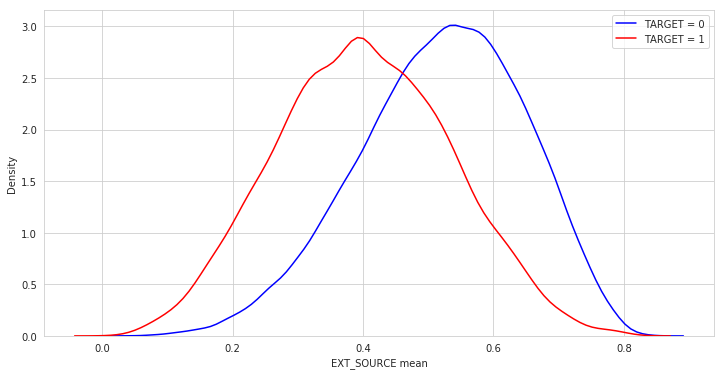

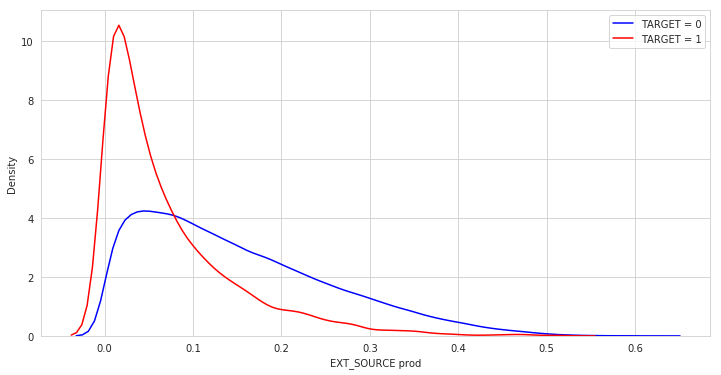

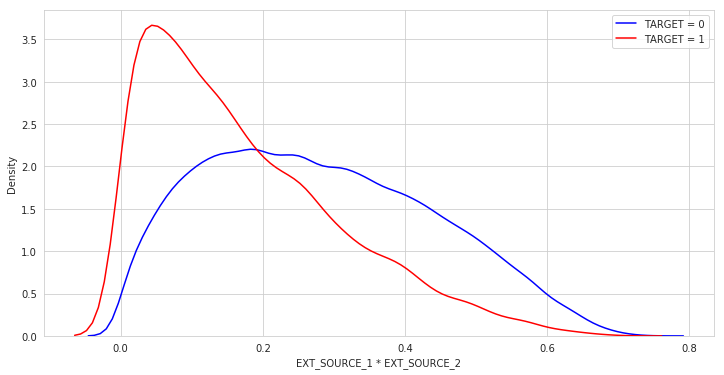

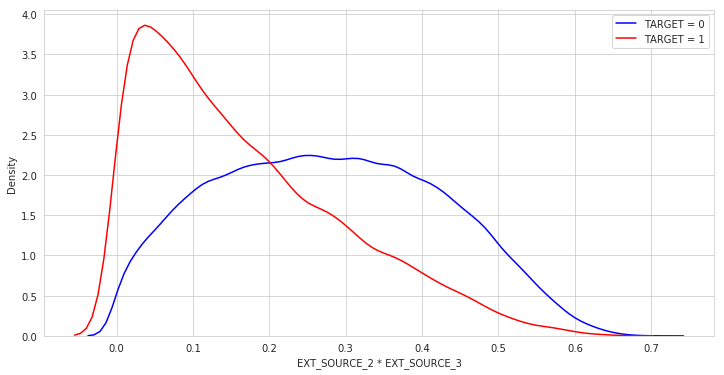

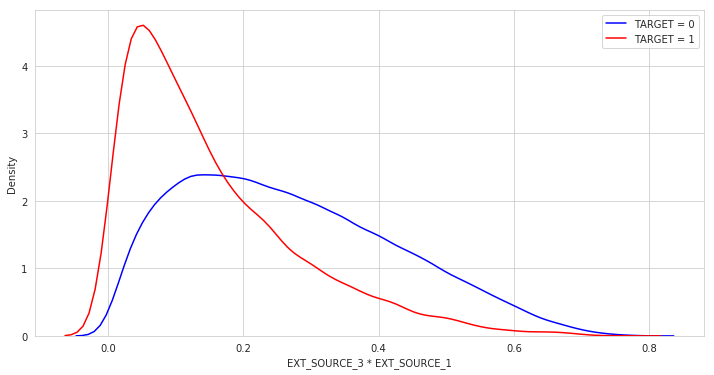

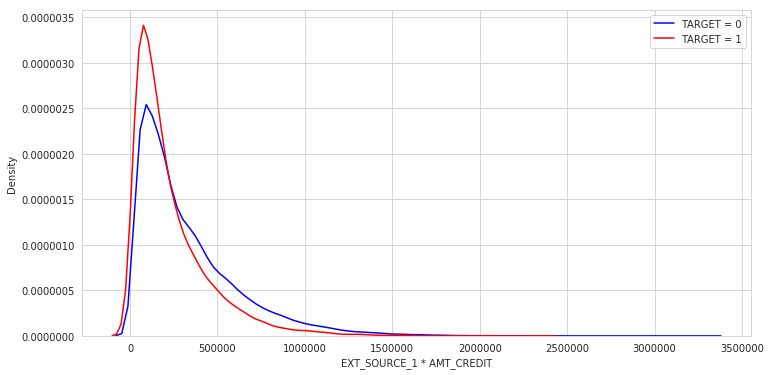

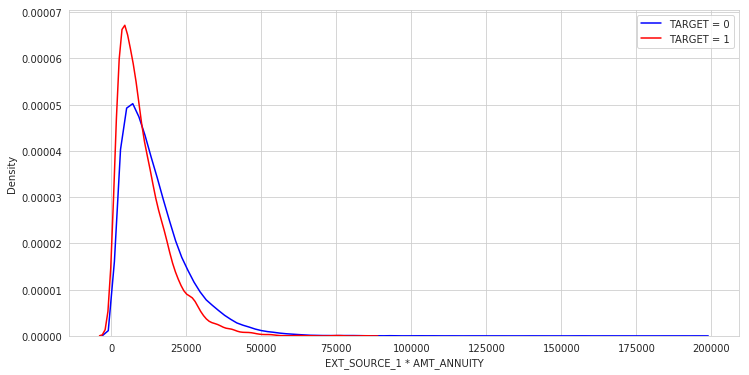

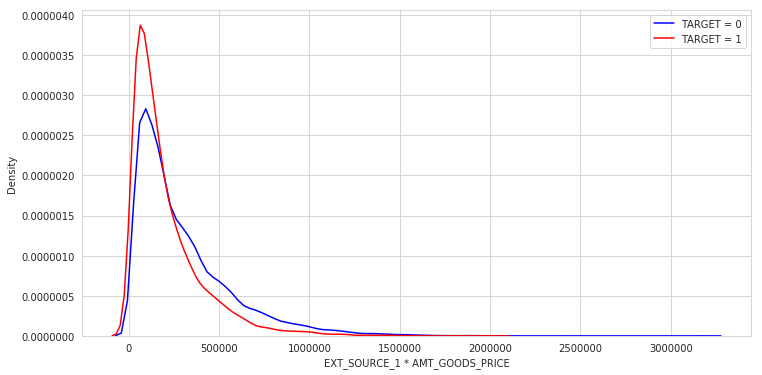

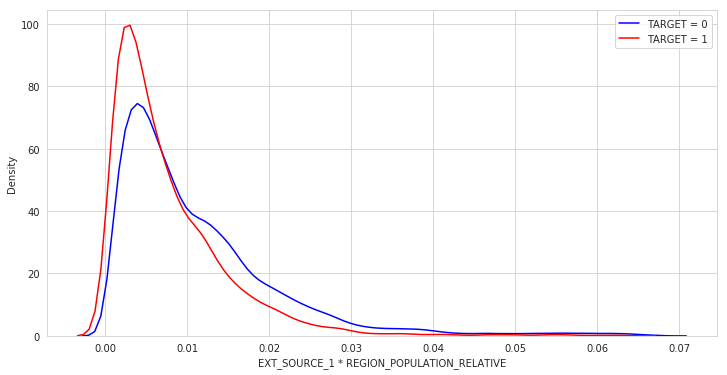

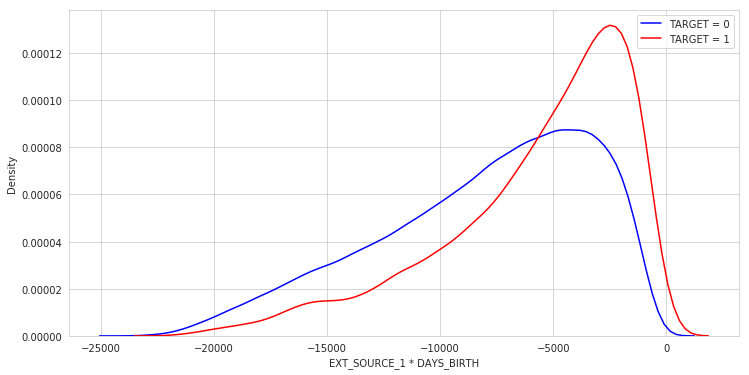

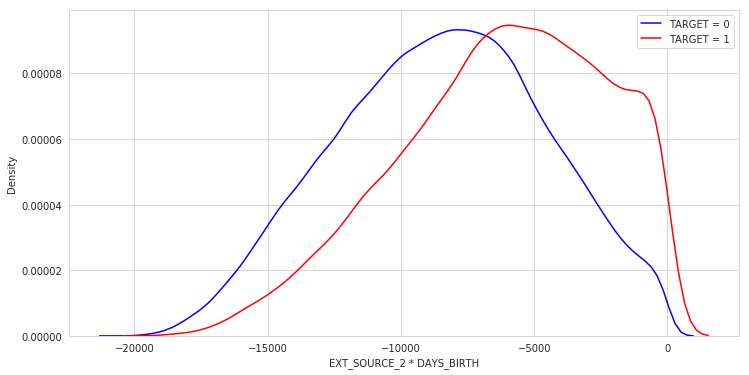

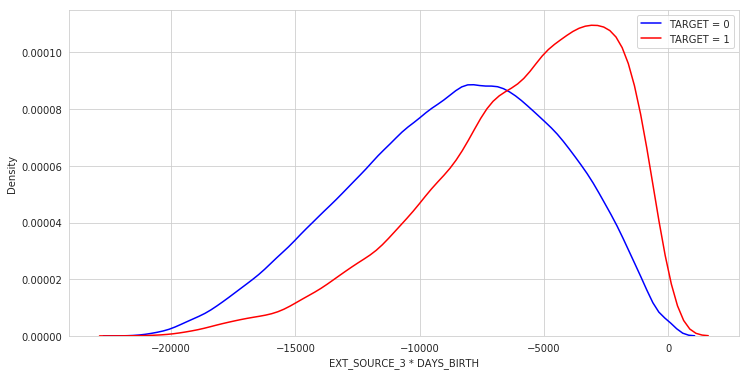

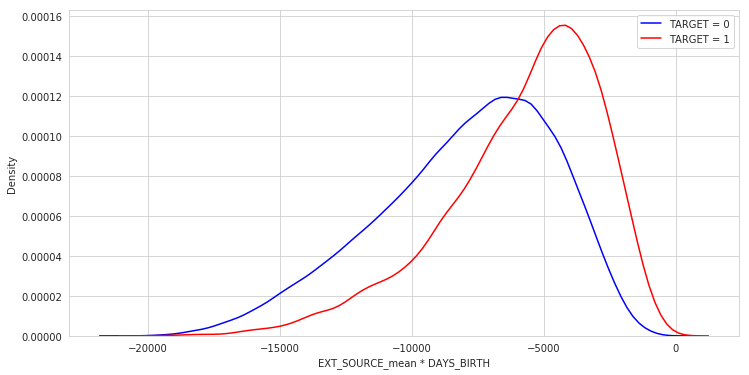

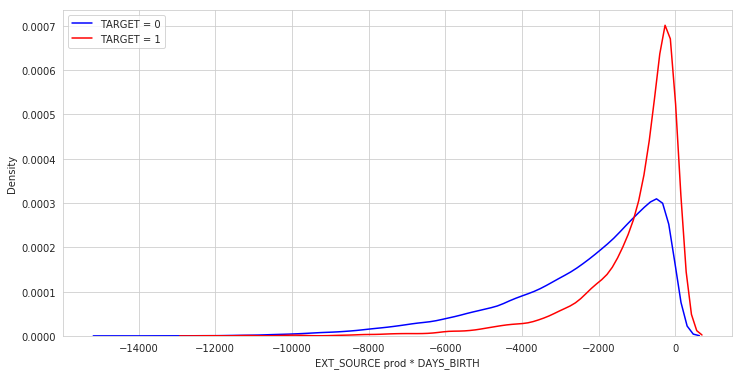

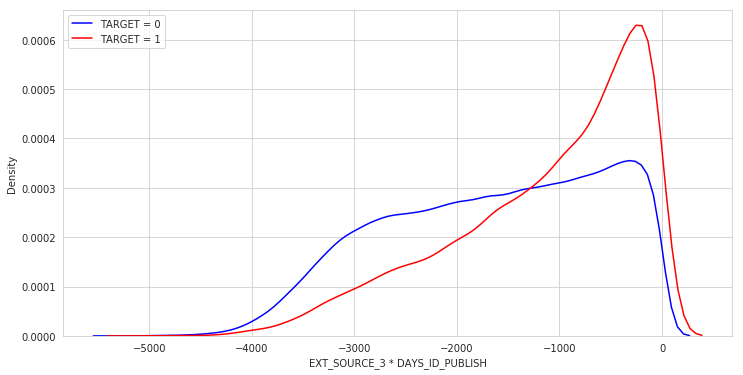

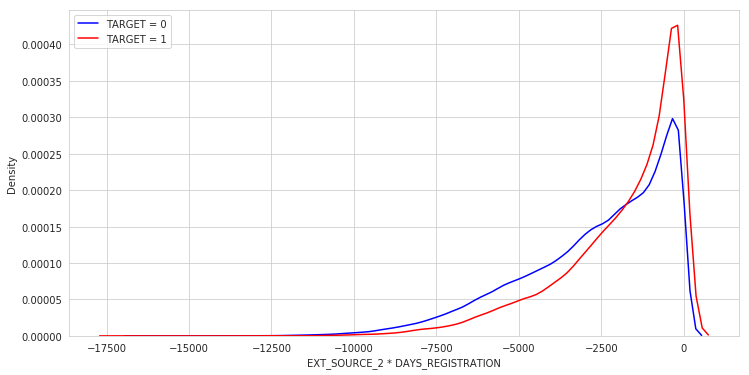

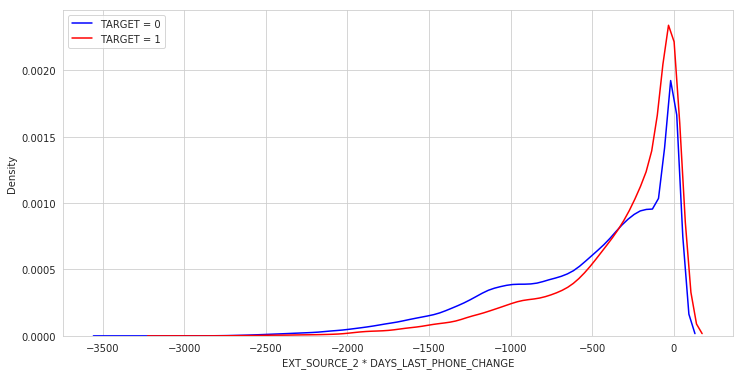

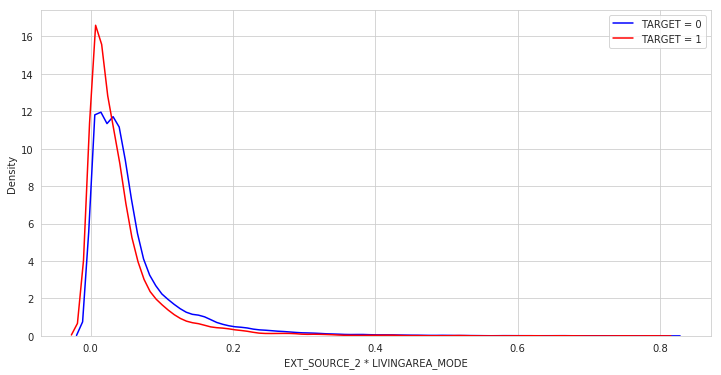

In [80]:
plot_float_feature(df_train_new_features, 'EXT_SOURCE mean', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE prod', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_1 * EXT_SOURCE_2', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_2 * EXT_SOURCE_3', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_3 * EXT_SOURCE_1', 'TARGET')

plot_float_feature(df_train_new_features, 'EXT_SOURCE_1 * AMT_CREDIT', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_1 * AMT_ANNUITY', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_1 * AMT_GOODS_PRICE', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_1 * REGION_POPULATION_RELATIVE', 'TARGET')

plot_float_feature(df_train_new_features, 'EXT_SOURCE_1 * DAYS_BIRTH', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_2 * DAYS_BIRTH', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_3 * DAYS_BIRTH', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_mean * DAYS_BIRTH', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE prod * DAYS_BIRTH', 'TARGET')

plot_float_feature(df_train_new_features, 'EXT_SOURCE_3 * DAYS_ID_PUBLISH', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_2 * DAYS_REGISTRATION', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_2 * DAYS_LAST_PHONE_CHANGE', 'TARGET')
plot_float_feature(df_train_new_features, 'EXT_SOURCE_2 * LIVINGAREA_MODE', 'TARGET')

In [81]:
df_train_new_features.drop('TARGET', axis=1, inplace=True)
columns_vocab[APPL_ID]['new_features'] = list(df_train_new_features.columns.values)

### Кодирование бинарных признаков

Часть бинарных признаков были закодированы не нулем и единицей, а какими-то значениями. Исправим это. 

In [82]:
def encoding_binary_features(df, features):
    df_binary_updated = pd.get_dummies(df[features], drop_first=True)
    df_binary_updated.columns = features
    df.drop(features, axis = 1, inplace = True)
    df = pd.concat([df, df_binary_updated], axis=1)
    return df

In [83]:
columns_binary_updated = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
                         'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']

In [84]:
df_application_train = encoding_binary_features(df_application_train, columns_binary_updated)
df_application_test = encoding_binary_features(df_application_test, columns_binary_updated)

print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 122)
application test: (48744, 121)


In [ ]:
columns_vocab[APPL_ID]['columns_binary'] = \
        columns_vocab[APPL_ID]['columns_binary'] + columns_binary_updated

for column in columns_binary_updated:
    columns_vocab[APPL_ID]['columns_category'].remove(column)

### OneHotEncode категориальных признаков

In [85]:
# Возвращает DataFrame с категориальными признаками OneHotEncode
def encoding_category_features(df, features):
    print('Number of category features:', len(features))
    
    # get_dummies не кодирует числовые значения
    for column in features:
        if df[column].dtype != 'object':
            df[column] = df[column].apply(lambda x: str(x))
        
    df_cat = pd.get_dummies(df[features], dummy_na=True)
    
    # удаление пустых колонок, которые могли появиться с пред.операции
    empty_columns = df_cat.loc[:, df_cat.sum(axis=0) == 0].columns
    df_cat.drop(empty_columns, axis=1, inplace=True)
    
    print('Number of encoded category features:', len(df_cat.columns))
    
    #df.drop(features, axis=1, inplace=True)
    #df = pd.concat([df, df_cat], axis=1)
    return df_cat

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test, target=None):
    common_feat = list( set(train.keys()) & set(test.keys()))
    
    if target: 
        train_feat = [target] + common_feat
    else:
        train_feat = common_feat
    
    test_feat = common_feat
    
    return train[train_feat], test[test_feat]

In [86]:
category_features = columns_vocab[APPL_ID]['columns_category']
df_train_cat_features = encoding_category_features(df_application_train, category_features)
df_test_cat_features = encoding_category_features(df_application_test, category_features)

Number of category features: 23
Number of encoded category features: 282
Number of category features: 23
Number of encoded category features: 228


In [87]:
print('category features, train:', df_train_cat_features.shape)
print('category features, test:', df_test_cat_features.shape)

category features, train: (307511, 282)
category features, test: (48744, 228)


In [88]:
# Пересечение закодированных признаков в трейне и тесте
df_train_cat_features, df_test_cat_features = \
        intersect_features(df_train_cat_features, df_test_cat_features)

print('category features, train:', df_train_cat_features.shape)
print('category features, test:', df_test_cat_features.shape)

category features, train: (307511, 225)
category features, test: (48744, 225)


In [89]:
# Сохранение названий новых закодированных признаков
category_features_ohe = df_train_cat_features.columns.values
columns_vocab[APPL_ID]['columns_category_ohe'] = list(category_features_ohe)

In [90]:
# Удаление старых категориальных признаков из исходного датасета
df_application_train.drop(category_features, axis=1, inplace=True)
df_application_test.drop(category_features, axis=1, inplace=True)

# Добавление новых закодированных категориальных признаков
df_application_train = pd.concat([df_application_train, df_train_cat_features], axis=1)
df_application_test = pd.concat([df_application_test, df_test_cat_features], axis=1)

In [91]:
print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 324)
application test: (48744, 323)


### Логарифмирование признаков

Я заметила, что некоторые признаки имеют длинный правый хвост в распределении. Попробуем сделать логарифмирование, вдруг немного поможет потом.

In [92]:
def log_feature(df, new_df, column, delta):
    new_df[column+'_log'] = df[column].apply(lambda x: np.log(delta) if np.isnan(x) else np.log(x+delta))

In [93]:
# обновить список признаков: вместо признака подставляем логарифм.признак
def update_features_list(features, features_for_log):
    updated_features = []
    for feat in features: 
        if feat in features_for_log: 
            updated_features.append(feat+'_log')
        else: 
            updated_features.append(feat)
            
    return updated_features

In [94]:
df_train_log_features = pd.DataFrame()
df_test_log_features = pd.DataFrame()

# временно: нужно для отрисовки графиков
df_train_log_features['TARGET'] = df_application_train['TARGET']

features_for_log = [
    'AMT_INCOME_TOTAL', 
    
    'OBS_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 
    'DEF_60_CNT_SOCIAL_CIRCLE'
]

updated_features_float = update_features_list(columns_vocab[APPL_ID]['columns_float'], features_for_log)
updated_features_social_circle = update_features_list(columns_vocab[APPL_ID]['columns_float_social_circle'], features_for_log)

for feat in features_for_log:
    log_feature(df_application_train, df_train_log_features, feat, delta=0.001)
    log_feature(df_application_test, df_test_log_features, feat, delta=0.001)

In [95]:
# Сохранение названий преобразованных признаков в словарь
columns_vocab[APPL_ID]['columns_float_log'] = updated_features_float
columns_vocab[APPL_ID]['columns_social_circle_log'] = updated_features_social_circle

In [96]:
print('log features, train:', df_train_log_features.shape)
print('log features, test:', df_test_log_features.shape)

log features, train: (307511, 6)
log features, test: (48744, 5)


Ну и можно заодно посмотреть на распределения преобразованных признаков, после логафмирования должно быть нагляднее: 

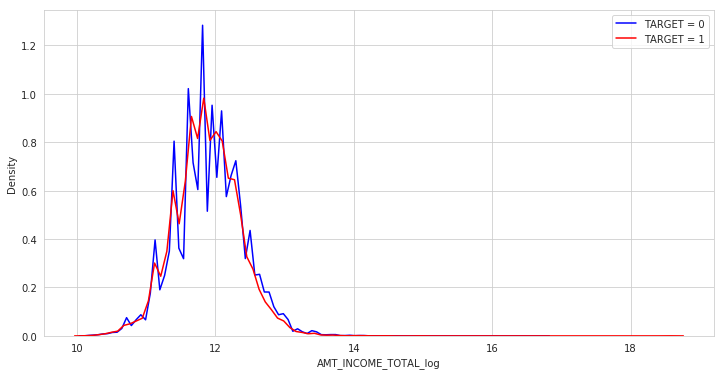

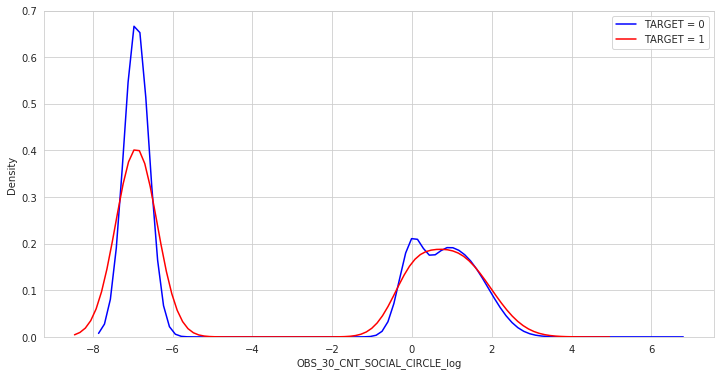

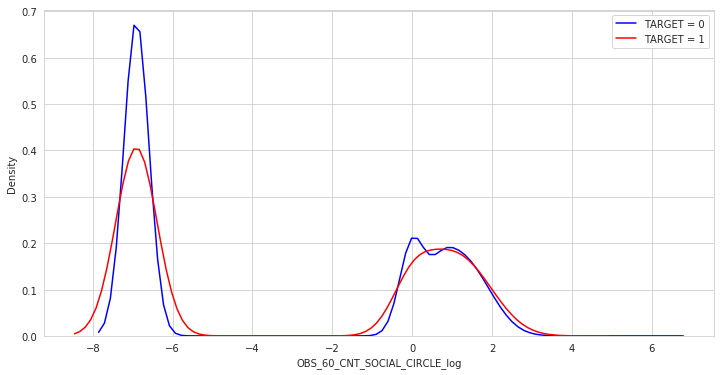

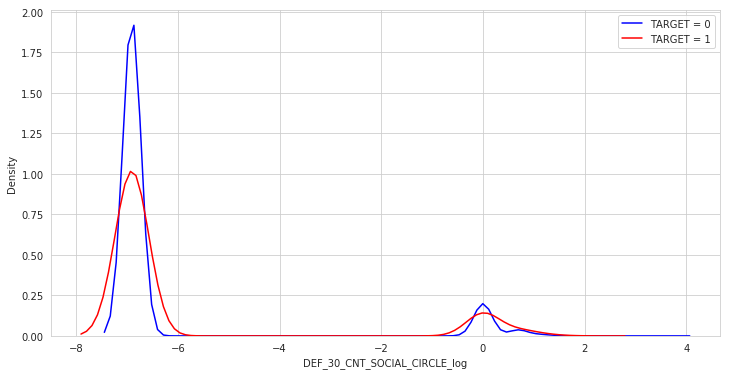

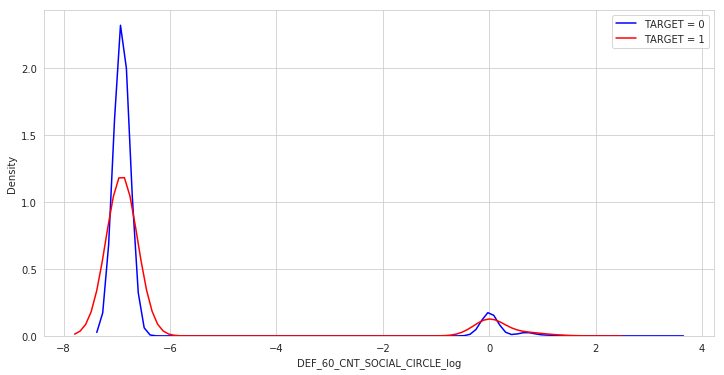

In [97]:
plot_float_feature(df_train_log_features, 'AMT_INCOME_TOTAL_log', 'TARGET')
plot_float_feature(df_train_log_features, 'OBS_30_CNT_SOCIAL_CIRCLE_log', 'TARGET')
plot_float_feature(df_train_log_features, 'OBS_60_CNT_SOCIAL_CIRCLE_log', 'TARGET')
plot_float_feature(df_train_log_features, 'DEF_30_CNT_SOCIAL_CIRCLE_log', 'TARGET')
plot_float_feature(df_train_log_features, 'DEF_60_CNT_SOCIAL_CIRCLE_log', 'TARGET')

In [98]:
# Удаление временной колонки
df_train_log_features.drop('TARGET', axis=1, inplace=True)

### Заполнение пропусков

Пропуски в категориальных переменных закодировались, остались вещественные. 

Здесь я решила пропуски не заполнять разными средними, медианами и т.д., так как пропущенных значений очень много и я предполагаю, что для "деревянных" моделей такое подход будет полезнее. Посмотрев на разброс значений, выберем константу.

In [99]:
FILL_NA_CONST = -999

In [100]:
# MAIN DF
df_application_train.fillna(FILL_NA_CONST, inplace=True)
df_application_test.fillna(FILL_NA_CONST, inplace=True)

In [101]:
print('Проверка. Число колонок с пропущенными значениями:')
print('train:', (df_application_train.describe().loc['count', :].values < df_application_train.shape[0]).sum())
print('test:', (df_application_test.describe().loc['count', :].values < df_application_test.shape[0]).sum())

Проверка. Число колонок с пропущенными значениями:
train: 0
test: 0


In [102]:
# NEW FEATURES DF
df_train_new_features.fillna(FILL_NA_CONST, inplace=True)
df_test_new_features.fillna(FILL_NA_CONST, inplace=True)

### Сохранение новых данных

На всякий случай проверим размерности таблиц и что мы ничего не потеряли по дороге и сохраним все. 

In [103]:
print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 324)
application test: (48744, 323)


In [104]:
print(df_train_new_features.shape)
print(df_test_new_features.shape)

(307511, 45)
(48744, 45)


In [105]:
print('log features, train:', df_train_log_features.shape)
print('log features, test:', df_test_log_features.shape)

log features, train: (307511, 5)
log features, test: (48744, 5)


In [106]:
columns_vocab[APPL_ID].keys()

dict_keys(['column_id', 'column_target', 'columns_binary', 'columns_category', 'columns_float', 'columns_float_avg', 'columns_float_mode', 'columns_float_medi', 'columns_float_social_circle', 'new_features', 'columns_category_ohe', 'columns_float_log', 'columns_social_circle_log'])

------------------------

In [107]:
with open('df_application_train_upd.pkl', 'wb') as f: 
    pickle.dump(df_application_train, f)
    
with open('df_application_test_upd.pkl', 'wb') as f: 
    pickle.dump(df_application_test, f)

In [108]:
with open('df_train_new_features.pkl', 'wb') as f: 
    pickle.dump(df_train_new_features, f)
    
with open('df_test_new_features.pkl', 'wb') as f: 
    pickle.dump(df_test_new_features, f)

In [109]:
with open('df_train_log_features.pkl', 'wb') as f: 
    pickle.dump(df_train_log_features, f)
    
with open('df_test_log_features.pkl', 'wb') as f: 
    pickle.dump(df_test_log_features, f)

In [110]:
with open('columns_vocab.pkl', 'wb') as f: 
    pickle.dump(columns_vocab, f)